# Приоритезация гипотез и проведение A/B-теста

## Описание проекта
Являясь аналитиком крупного интернет-магазина, совместно с отделом маркетинга мы подготовили список гипотез для увеличения выручки

## Цели проекта
- Приоритизировать гипотезы
- Запустить A/B-тест 
- Проанализировать результаты 

## Описание данных

**Таблица hyp**

`Hypothesis` — краткое описание гипотезы\
`Reach` — охват пользователей по 10-балльной шкале\
`Impact` — влияние на пользователей по 10-балльной шкале\
`Confidence` — уверенность в гипотезе по 10-балльной шкале\
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

**Таблица orders**

`transactionId` — идентификатор заказа\
`visitorId` — идентификатор пользователя, совершившего заказ\
`date` — дата, когда был совершён заказ\
`revenue` — выручка заказа\
`group` — группа A/B-теста, в которую попал заказ

**Таблица visitors**

`date` — дата\
`group` — группа A/B-теста\
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## План работы

1. Изучить данные о гипотезах
2. Приоритезировать гипотезы, посредством методов `ICE` и `RICE`, посмотреть отличия
3. Провести анализ A/B-теста
4. Принять решение о продолжении проведения тестирования

### Знакомство с данными

Для начала загрузим необходимые библиотеки для работы

In [1]:
import pandas as pd

In [2]:
import datetime as dt

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import scipy.stats as stats

Посмотрим на данные из трёх таблиц `hyp`, `orders` и `visitors`, приведем название столбцов к нижнему регистру (где это необходимо)

In [6]:
hyp = pd.read_csv('/datasets/hypothesis.csv')

In [7]:
orders = pd.read_csv('/datasets/orders.csv')

In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [9]:
pd.options.display.max_colwidth = 130

In [10]:
hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [11]:
hyp.columns = hyp.columns.str.lower()

Также стоит проверить таблицы `orders` и `visitors` на наличие пропусков и дубликатов

In [12]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [13]:
orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'}, inplace = True)

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   orderId  1197 non-null   int64 
 1   userId   1197 non-null   int64 
 2   date     1197 non-null   object
 3   revenue  1197 non-null   int64 
 4   group    1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [15]:
orders.duplicated().sum()

0

In [16]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
visitors.duplicated().sum()

0

При проверке на наличие пропусков и дубликатов их не обнаружено. Проведем ещё несколько исследований для лучшего знакомства с днными. Посмотрим группы, которые у нас участвуют в исследовании, и дату начала и окончания теста

In [19]:
orders.date.agg({'min','max'})

min    2019-08-01
max    2019-08-31
Name: date, dtype: object

In [20]:
visitors.date.agg({'min','max'})

min    2019-08-01
max    2019-08-31
Name: date, dtype: object

Посмотрим сколько у нас пользователей в группах

In [21]:
orders.group.value_counts()

B    640
A    557
Name: group, dtype: int64

А теперь посмотрим сколько у нас уникальных пользователей в обоих группах

In [22]:
orders.groupby('userId')['group'].agg(('nunique')).count()

1031

В исследовании участвуют две группы А и В, в одной из них 640 человек, а в другой 557, из них уникальных пользователей 1031, то есть остальная часть присутствует в обоих группах. Посмотрим сколько пользователей присутствуют в обоих группах

In [23]:
A = orders.query('group == "A"')['userId']

In [24]:
B = orders[orders['group'] == 'B']['userId']

In [25]:
A.isin(B).sum()

89

89 пользователей из группы А есть в группе В, для нашего теста не критично, участие пользователей в обоих группах

### Часть 1. Приоритизация гипотез.

После знакомства с таблицами можно приступать к первой части задания: приоритезации гипотез. Напомню, что для приоритезации гипотез мы будем использовать методы `ICE` и `RICE`

In [26]:
hyp['ICE'] = round((hyp['impact']*hyp['confidence'])/hyp['efforts'],2)

In [27]:
hyp[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


При проведении приоритезации методом `ICE` мы получили тройку лидеров - это 8, 0 и 7 гипотеза, посмотрим, что покажет тест `RICE`

In [28]:
hyp.hypothesis[8]

'Запустить акцию, дающую скидку на товар в день рождения'

In [29]:
hyp.hypothesis[0]

'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'

In [30]:
hyp.hypothesis[7]

'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

In [31]:
hyp['RICE'] = (hyp['reach']*hyp['impact']*hyp['confidence'])/hyp['efforts']

In [32]:
hyp[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При проведение приоритезации методом `RICE` тройка лидеров изменилась, ими стали 7, 2 и 0 гипотеза. Сравним данные для большей наглядности

In [33]:
hyp[['hypothesis', 'ICE', 'RICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


Итак, мы получили пять гипотез с оценкой выше 5 баллов по методу `ICE`, это гипотезы под индексами 8, 0, 7, 6 и 2, именно на проверку этих гипотез необходимо сфокусировать внимание команды. Выведем описание данных гипотез, гипотезы под индексами 8,0 и 7 мы выводили в предыдущем тесте, а гипотезы под индексами 2 и 6 выведем ниже

*P.S.* Различия в приоритезации гипотез возникают главным образов из-за параметра `reach` - охват (показывает скольких пользователей затронет изменение, которое вы хотите внести), наппример у 8 гипотезы при проведение оценки методом `ICE` самый высокий результат, но из-за того, что показатель `reach` оценен в 1 балл, она проиграла 7 гипотезе, где этот же показатель оценен в 10 баллов

In [34]:
hyp.hypothesis[2]

'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'

In [35]:
hyp.hypothesis[6]

'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию'

### Часть 2. Анализ A/B-теста

Сначала преобразуем поля с датами в обоих таблицах, приведем их к единому формату Y-m-d с помощью функции `dt.datetime.strptime`  библиотеки `datetime`

In [36]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [37]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Создадим массив уникальных пар значений дат и групп теста методом `drop_duplicates()`

In [38]:
dateGroups = orders[['date','group']].drop_duplicates() 

Далее создадим две переменные `ordersAggregated` и `visitorsAggregated`, в них мы посчитаем кумулятивные данные о заказах и о посетителях по дням

In [39]:
ordersAggregated = dateGroups\
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [40]:
ordersAggregated.head()

,date,group,orderId,userId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [41]:
visitorsAggregated = dateGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [42]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Теперь соединим данные о заказах и посетителях, создав новую переменную cumulativeData и использовав функцию `merge` для объединения. Переименуем столбцы для работы с таблицей

In [43]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Посмотрим правильно ли создан датафрейм `cumulativeData` для этого посмотрим дату начала и окончания эксперимента, напомним, изначально эти даты были определены с 01-08-2019 по 31-08-2019

In [44]:
cumulativeData.date.min()

Timestamp('2019-08-01 00:00:00')

In [45]:
cumulativeData.date.max()

Timestamp('2019-08-31 00:00:00')

Даты совпадают, мы можем сделать вывод, что датафрейм построен правильно

У нас есть таблица с кумулятивными данными о заказах и посетителях, теперь можно приступать к анализу

Первым делом, мы посмотрим на **`кумулятивую выручку`** по группам и построим график

In [46]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [47]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

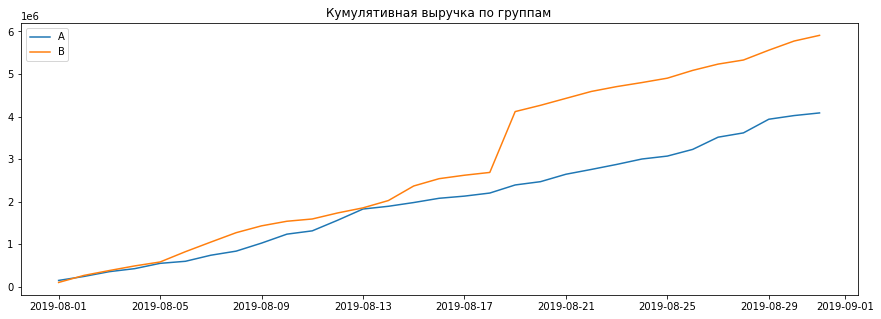

In [48]:
plt.figure(figsize=[15,5])
plt.title('Кумулятивная выручка по группам')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend();

Из графиков видно, что пользователи группы В приносят выручку больше, чем пользователи из группы А, но пока неясна причина такого поведения графика, нужно проверить что именно повлияло на увеличение выручки - средний чек группы В или количество заказов этой группы. Посмотрим на различие **`среднего чека`** групп, для этого мы поделим общюю выручку на общее число заказов для каждой из групп 

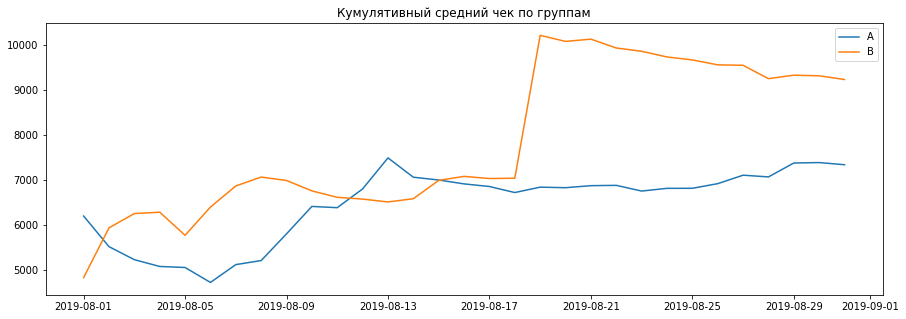

In [49]:
plt.figure(figsize=[15,5])
plt.title('Кумулятивный средний чек по группам')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();

Здесь мы также видим превосходство группы В над группой А, похоже, что в последнии числа августа число заказов группы В возросло, поэтому вырос и средний чек заказов, или это просто выбросы, необходимо это выяснить

Объединим таблицы кумулятивных значений групп А и В для построения графика **`относительного изменения кумулятивного среднего чека группы B к группе A `**

In [50]:
mergedCumulativeRevenue = cumulativeRevenueA\
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

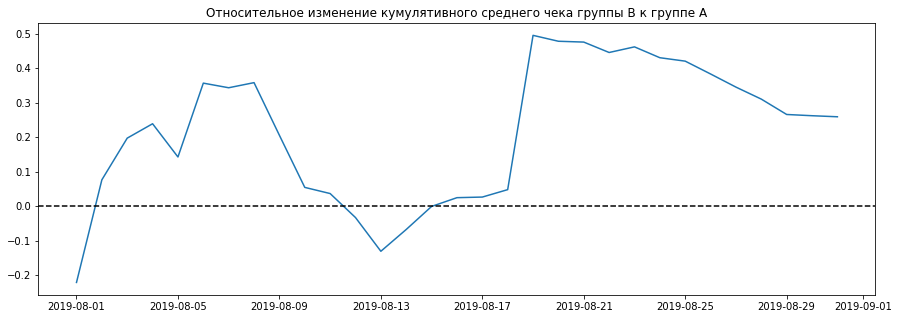

In [51]:
plt.figure(figsize=[15,5])
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.plot(mergedCumulativeRevenue['date'],\
(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) -1)
plt.axhline(y=0, color='black', linestyle='--');

С течением времени средний чек группы В к группе А растет, за исключением 13 августа, где группа А вырвалась вперед, это же видно и на предыдущем графике `среднего чека` для двух групп. В нескольких точках график различия между сегментами резко «скачет», это происходит из-за крупных заказов и выбросов, далее в анализе мы посмотрим на эти данные конкретнее

Сначало посмотрим на **`среднее количество заказов`** в общем по двум группам, для этого сгруппируем данные по `userId` и посчитаем количество уникальных заказов на пользователя

In [52]:
ordersByUsers = orders.groupby('userId', as_index=False).agg({'orderId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']

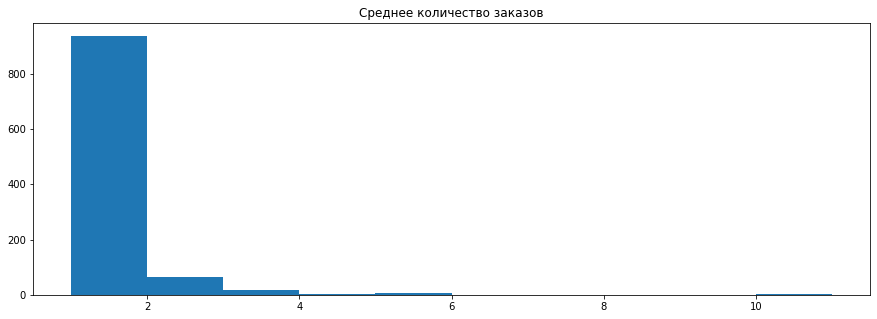

In [53]:
plt.figure(figsize=[15,5])
plt.title('Среднее количество заказов')
plt.hist(ordersByUsers['orders']);

Посмотрим на другом виде графика

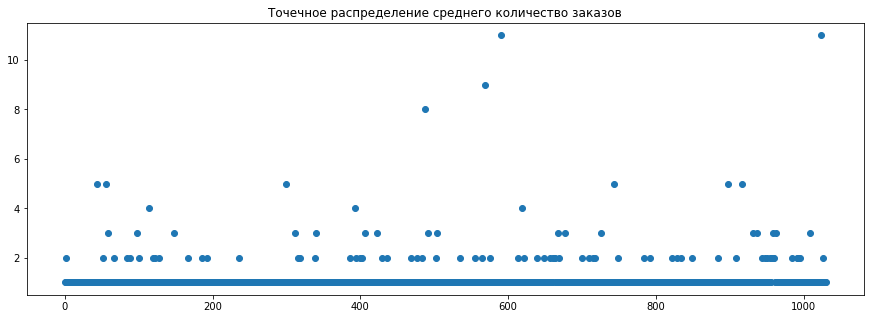

In [54]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=[15,5])
plt.title('Точечное распределение среднего количество заказов')
plt.scatter(x_values, ordersByUsers['orders']);

Из графиков видно, что большинство пользователей совершали не больше 3 заказов, но есть те, кто совершил 10 заказов, похоже на выбросы в данных или заядлого шопоголика

Теперь посмотрим на **`среднее распределение заказов по группам`**, для этого создадим переменные `cumulativeOrdersA` и `cmulativeOrdersB`, где посмотрим кумулятивное распределение заказов по группам и датам

In [55]:
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','orders', 'visitors', 'revenue']]

In [56]:
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','orders', 'visitors', 'revenue']]

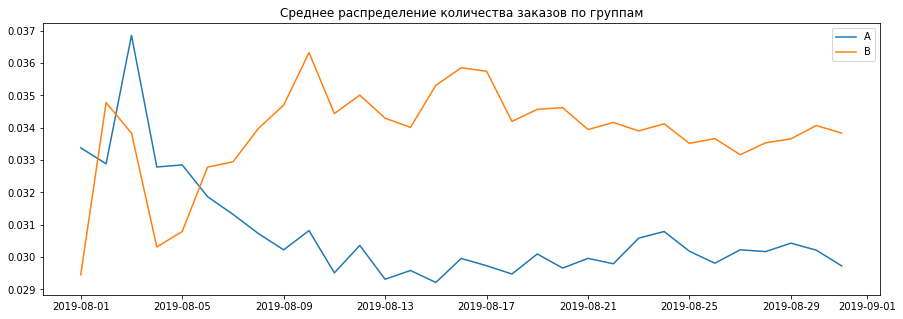

In [57]:
plt.figure(figsize=[15,5])
plt.title('Среднее распределение количества заказов по группам')
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders'] / cumulativeOrdersA['visitors'], label='A')
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders'] / cumulativeOrdersB['visitors'], label='B')
plt.legend();

Из графика видно, что количество заказов в первых числах августа было больше у группы А, но, начиная с 7 августа группа В опережает группу А по количеству заказов за день, это отличная новость для бизнеса и победу можно было бы отдать группе В, но ещё рано делать выводы. Посмотрим на график **`относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A`**

In [58]:
mergedCumulativeOrders = cumulativeOrdersA\
.merge(cumulativeOrdersB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

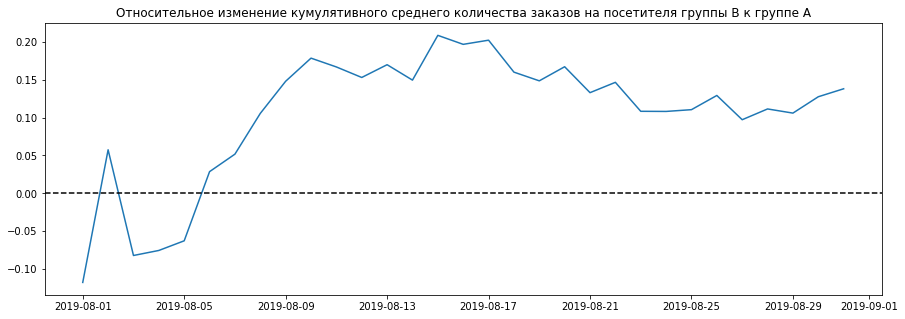

In [59]:
plt.figure(figsize=[15,5])
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.plot(mergedCumulativeOrders['date'],\
((mergedCumulativeOrders['ordersB'] / mergedCumulativeOrders['visitorsB'])\
/(mergedCumulativeOrders['ordersA'] / mergedCumulativeOrders['visitorsA']) -1))
plt.axhline(y=0, color='black', linestyle='--');

Изначально с заказами в группе В были небольшие проблемы, но после 8 августа ситуация начала меняться и количество заказов начало расти

Посчитаем **`95-й и 99-й перцентили количества заказов на пользователя`** для определения границы аномальных пользователей

In [60]:
ord = np.percentile(ordersByUsers['orders'], [95,99])

In [61]:
ord

array([2., 4.])

Можно сделать вывод, что всего 1% пользователей делают больше 4 заказов, большее количество заказов делают аномальные любители покупок

Посмотрим на **`точечный график стоимостей заказов`** для группы А и группы В

In [62]:
ordersA = orders.query('group == "A"')
x_values = pd.Series(range(0,len(ordersA['revenue'])))

In [63]:
ordersB = orders.query('group == "B"')
y_values = pd.Series(range(0,len(ordersB['revenue'])))

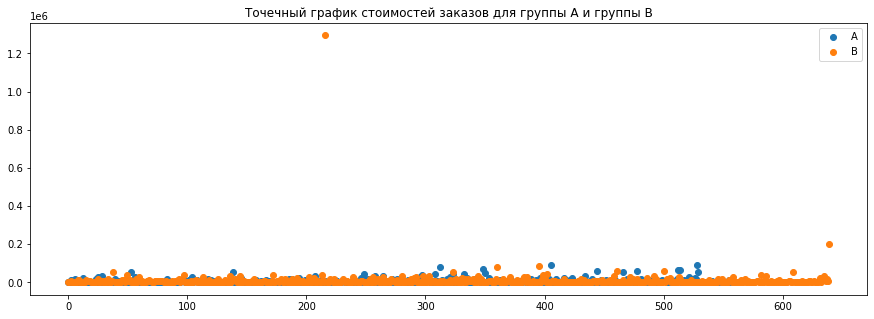

In [64]:
plt.figure(figsize=[15,5])
plt.title('Точечный график стоимостей заказов для группы А и группы В')
plt.scatter(x_values, ordersA['revenue'], label='A')
plt.scatter(y_values , ordersB['revenue'], label='B')
plt.legend();

Из графика видно, что большинство заказов имеют стоимость около 200 00, но в группе В есть один заказ, стоимость которого больше 1 000 000 , это указывает, что в данных явно есть какие-то странности. Посчитаем **`95-й и 99-й перцентили стоимости заказов`**. чтобы определить границу "нормальности" стоимости заказов

In [65]:
cost = np.percentile(orders['revenue'], [95,99])

In [66]:
cost

array([28000. , 58233.2])

Мы получили, что всего 1 % стоимости заказов больше 582332, те заказы у которых стоимость выше этого числа являются аномально дорогими

Для того, чтобы понять на сколько будут различаться результаты по "сырым" и "очищенным" данным, нам необходимо посчитать **`статистическую значимость различий в среднем количестве заказов на посетителя между группами`** и **`статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным и по "очищенным" данным`**. Первое, что необходимо сделать создать две переменные `ordersByUsersA` и `ordesrByUsersB`, где мы сгрупируем данные по покупателям и посчитаем количество заказов по группам

In [67]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Далее объявим переменные `sampleA` и `sampleB`, в которых пользователям из каждой группы будет соответствовать количество заказов, которые они совершили. Тем, кто ничего не заказал, будут соответствовать нули. Таким способом мы подготавливаем выборки к проверке критерием Манна-Уитни. 

Переменная `sampleA` будет состоять из двух частей: списка с количеством заказов для каждого из пользователей `ordersByUsersA['orders']` и нулей для пользователей, которые ничего не заказывали. Их можно найти, посчитав разницу между суммой посетителей и количеством записей о заказах `data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])`

У нас нет данны о посещениях сайта по дням, поэтому мы их создадим и схраним в переменные `visitorsADaily` и `visitorsBDaily`

In [68]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

В объединении двух объектов Series используем функцию `pd.concat` и `axis=0` для объединения по строкам

In [69]:
sampleA = pd.concat([ordersByUsersA['orders'],\
pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],\
pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Теперь проведем проверку критерием Манна-Уитни, для этого используем метод `mannwhitneyu` библиотеки `stats`

**Гипотезы в A/B-тесте на статистическую значимость различий в среднем количестве заказов на посетителя между группами**\
`Н0`: Статистически значимых различий в данных между группами нет\
`Н1`: Статистически значимые различия в данных есть

Уровень статистической значимости `alpha` - 0.05

In [70]:
"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])

'0.017'

Мы получили p-value 0.017, что меньше чем 0.05, поэтому мы отвергаем нулевую гипотезу и признаем, что статистически значимые раличия между группами есть. Посмотрим на относительный прирост среднего числа заказов группы B. Для этого мы `среднее число заказов группы B / среднее число заказов группы A - 1`, посчитав среднее число заказов у каждой группы, применив функцию `mean()`

In [71]:
"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)

'0.138'

Относительный прирост среднего числа заказов группы B составляет почти 14%, что не может не радовать, на этом мы могли бы закончить эксперимент, но необходимо проверить эти цифры на "очищенных" даннных, выше мы посчитали границы количества заказов на пользователя и стоимости этих заказов, сделаем срезы по исходным данным

In [72]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > ord[1]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > ord[1]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > cost[1]]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)
abnormalUsers.shape[0]

15

Итак, мы получили 15 пользователей, которые выходят за "рамки" нашего исследования, теперь посмотрим на результаты без них. Для этого отфильтруем таблицы в переменных `sampleA` и`sampleB`, исключив пользователей, выше границ 99 процентиля

In [73]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [74]:
'{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

'0.014'

p-value уменьшился на 0.03, что подтверждает факт о том, что есть значительные различия в среднем количестве заказов 

In [75]:
'{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'0.153'

Группа В выигрывает у группы А по количеству заказов на 15%, это подталкивает к признанию победы группы В, но нам нужно провести тест Манна-Уитни ещё раз для подсчета статистической значимости среднего чека заказа

**Гипотезы в A/B-тесте на статистическую значимость различий в среднем чеке заказа между группами:**\
`Н0`: Статистически значимых различий в данных между группами нет\
`Н1`: Статистически значимые различия в данных есть

Уровень статистической значимости `alpha` - 0.05

In [76]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],
            orders[orders['group'] == 'B']['revenue'])[1])

'0.729'

p-value по данным без фильтрации равен 0.729, что выше 0.05 и говорит нам о том, что различий среднего чека групп А и В нет

In [77]:
'{0:.3f}'.format((orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean()) - 1)

'0.259'

При этом средний чек группы В выше среднего чека группы А почти на 26 %, наблюдаемые различия не являются значимыми при уровне значимости в 0.05, а следовательно были получены случайно.

In [78]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )

'0.851'

По очищенным данным значение p-value выросло ещё больше, что подтверждает, что различий среднего чека групп А и В нет

In [79]:
  "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )

'-0.006'

Разница между сегментами стала менее заметной, здесь видно, что группы выравнялись по показателю среднего чека

## Вывод

В первой части проекта, мы работали с таблицей `hyp`, в ней была информация о гипотезах, которые необходимо было приоритезировать. Проведя приоритезацию методами `ICE` и `RICE` мы выделили 5 наиболее перспективных гипотез.

Во второй части проекта мы работали с таблицами `orders` и `visitors`, в них была информация о датах проведения теста, пользователях, заказах, посещениях и прибыли. С помощью этих данных, мы провели A/B-тест на сравнение между группами. Проведя анализ результатов A/B-теста можно сделать следующие выводы: 

1. Статистически значемые различия между группами А и В есть в количестве заказов, а в средем чеке нет, это говорит нам, что группа А заказывают чаще, но на меньшую сумму, а группа В наоборот реже, но на более значительную сумму;
2. Кумулятивный средний чек по заказам выше у группы В, как и кумулятивная выручка;
3. Группа В выигрывает по большинству тестов и на графиках это видно, поэтому считаю разумным остановить тест и признать победу группы В 
4. Приоритезированные гипотезы разумнее проверять на группе В